<a href="https://colab.research.google.com/github/ramanshsharma2806/Flight-Price/blob/master/Flight_Price_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Flight Price

---

This model will predict flight prices based on [this](https://www.kaggle.com/zernach/2018-airplane-flights) data.

This model is being made for [mia](http://miamarketplace.com/), a place for people to run machine learning models interactively on the web.

In [1]:
#@title Google Drive mounting
"""
need to mount the drive to access the data
"""

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Require libraries import cell
"""
required libraries imported
"""

! pip install category_encoders
import category_encoders as ce

from __future__ import print_function
import os, io, sys, random, time, pprint
import numpy as np
from numpy import save, load
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.callbacks import LambdaCallback, Callback, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend
from tensorflow.keras.layers import Activation, Reshape, Dense, Embedding, Dropout, Input, BatchNormalization, concatenate, Flatten, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# SOME CONSTANTS
checkpoint_dir = '/content/drive/My Drive/MIA/best_model.hdf5'
model_preds_train = '/content/drive/My Drive/MIA/train_preds.npy'
model_preds_test = '/content/drive/My Drive/MIA/test_preds.npy'
truth_train = '/content/drive/My Drive/MIA/truth_train.npy'
truth_test = '/content/drive/My Drive/MIA/truth_test.npy'
train_continuous_dir = '/content/drive/My Drive/MIA/train_continuous_dir.npy'
test_continuous_dir = '/content/drive/My Drive/MIA/test_continuous_dir.npy'
train_categorical_dir = '/content/drive/My Drive/MIA/train_categorical_dir.npy'
test_categorical_dir = '/content/drive/My Drive/MIA/test_categorical_dir.npy'

     |████████████████████████████████| 81kB 2.5MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#@title TPU/GPU test
"""
testing if connected to TPU and/or GPU
"""

if 'COLAB_TPU_ADDR' not in os.environ:
  print('Not connected to a TPU runtime.')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('Connected to TPU.\n\nTPU address is', tpu_address)

  with tf.compat.v1.Session((tpu_address)) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

if tf.test.gpu_device_name() == '':
  print('\n\nNot connected to a GPU runtime.')
else:
  print('\n\nConnected to GPU: ' + tf.test.gpu_device_name())

Connected to TPU.

TPU address is grpc://10.5.189.250:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 1688492494024835235),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, -8698288555515767887),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, -434890094443013394),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3354990149447101817),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, -1698911867621656474),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 5998963836043072379),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, -2140136059092655729),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 151803466364537658),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869

# Assumptions about the data



## 1.   ItinID and MktID are ambiguous columns that do not seem to be significant towards predicting the flight price. The order in which the tickets are bought should not, in an obvious manner, affect how much an airline will charge for a flight. ticket. Ergo, these columns will be deleted.
## 2. The OriginWac and DestWac columns are useless too. They are just arbirary US State/Territory World Area Code that will not affect the flight price. They shall be removed.
## 3.   Several columns are categorical. In order to deal with categorical and contnuous data at the same time, we will use [this](https://datascience.stackexchange.com/questions/29634/how-to-combine-categorical-and-continuous-input-features-for-neural-network-trai) technique. The categorical inputs will be run through an Embedding layer and a small neural network, and then their outputs will be concantenated as inputs with the continuous data.

## 4. The categorical data columns are: Origin, Dest, and AirlineCompany.

## 5. ContiguousUSA is already a numerical variable with the values being [2, 1]. It does not need to be converted to numerical values, instead just needs to be normalized.



In [5]:
"""
reading data
"""

path = "/content/drive/My Drive/MIA/Cleaned_2018_Flights.csv"

df = pd.read_csv(path)

df

,Unnamed: 0,ItinID,MktID,MktCoupons,Quarter,Origin,OriginWac,Dest,DestWac,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany,PricePerTicket
0,0,20181767585,2018176758501,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,672.87
1,1,20181767586,2018176758601,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,367.68
2,2,20181767587,2018176758701,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,417.94
3,3,20181767636,2018176763601,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,247.10
4,4,20181767637,2018176763701,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,276.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9534412,9534412,201844999082,20184499908202,1,4,STL,64,AUS,74,721.0,2,1.0,WN,310.10
9534413,9534413,201844999092,20184499909203,1,4,BNA,54,MCI,64,491.0,2,1.0,WN,106.17
9534414,9534414,201844999112,20184499911203,1,4,BOS,13,LIT,71,1260.0,2,1.0,WN,161.19
9534415,9534415,201844999113,20184499911303,1,4,BOS,13,LIT,71,1260.0,2,1.0,WN,170.87


In [6]:
"""
scaling the target Y price values
"""

bool_scale = False

if bool_scale:
  df['PricePerTicket'] = df['PricePerTicket'] / 1000.0 # scaling the target

df

,Unnamed: 0,ItinID,MktID,MktCoupons,Quarter,Origin,OriginWac,Dest,DestWac,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany,PricePerTicket
0,0,20181767585,2018176758501,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,672.87
1,1,20181767586,2018176758601,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,367.68
2,2,20181767587,2018176758701,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,417.94
3,3,20181767636,2018176763601,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,247.10
4,4,20181767637,2018176763701,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA,276.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9534412,9534412,201844999082,20184499908202,1,4,STL,64,AUS,74,721.0,2,1.0,WN,310.10
9534413,9534413,201844999092,20184499909203,1,4,BNA,54,MCI,64,491.0,2,1.0,WN,106.17
9534414,9534414,201844999112,20184499911203,1,4,BOS,13,LIT,71,1260.0,2,1.0,WN,161.19
9534415,9534415,201844999113,20184499911303,1,4,BOS,13,LIT,71,1260.0,2,1.0,WN,170.87


In [7]:
"""
removing the first three unnecessary columns
removing OriginWac and DestWac because they are useless
"""

df.drop(['Unnamed: 0', 'ItinID', 'MktID', 'OriginWac', 'DestWac'], axis=1, inplace=True) # dropping index_col, ItinID, and MktID, OriginWac, DestWac

df

,MktCoupons,Quarter,Origin,Dest,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany,PricePerTicket
0,1,1,PHL,LAX,2402.0,2,1.0,AA,672.87
1,1,1,PHL,LAX,2402.0,2,1.0,AA,367.68
2,1,1,PHL,LAX,2402.0,2,1.0,AA,417.94
3,1,1,PHL,LAX,2402.0,2,1.0,AA,247.10
4,1,1,PHL,LAX,2402.0,2,1.0,AA,276.35
...,...,...,...,...,...,...,...,...,...
9534412,1,4,STL,AUS,721.0,2,1.0,WN,310.10
9534413,1,4,BNA,MCI,491.0,2,1.0,WN,106.17
9534414,1,4,BOS,LIT,1260.0,2,1.0,WN,161.19
9534415,1,4,BOS,LIT,1260.0,2,1.0,WN,170.87


## Applying the different types of encodings for all the variables.

In [8]:
"""
moving around a couple of variables
"""

# making the target variable the last one
temp_col = df['PricePerTicket']
df.drop('PricePerTicket', axis=1, inplace=True)
df['PricePerTicket'] = temp_col

# placing the two continuous variables in the beginning
tickets_col = df.pop('NumTicketsOrdered')
df.insert(0, 'NumTicketsOrdered', tickets_col)
miles_col = df.pop('Miles')
df.insert(0, 'Miles', miles_col)

# normalizing Quarter, Miles, and NumTicketsOrdered variables================================================
bool_norm = True
norm_vars = ['Miles', 'NumTicketsOrdered']

if bool_norm:
  for col in norm_vars:
    df[col] = df[col] / df[col].max()
# ===========================================================================================================

df

,Miles,NumTicketsOrdered,MktCoupons,Quarter,Origin,Dest,ContiguousUSA,AirlineCompany,PricePerTicket
0,0.471443,0.05,1,1,PHL,LAX,2,AA,672.87
1,0.471443,0.05,1,1,PHL,LAX,2,AA,367.68
2,0.471443,0.05,1,1,PHL,LAX,2,AA,417.94
3,0.471443,0.05,1,1,PHL,LAX,2,AA,247.10
4,0.471443,0.05,1,1,PHL,LAX,2,AA,276.35
...,...,...,...,...,...,...,...,...,...
9534412,0.141511,0.05,1,4,STL,AUS,2,WN,310.10
9534413,0.096369,0.05,1,4,BNA,MCI,2,WN,106.17
9534414,0.247301,0.05,1,4,BOS,LIT,2,WN,161.19
9534415,0.247301,0.05,1,4,BOS,LIT,2,WN,170.87


## First we separate the X and Y into training and testing datasets.

In [9]:
"""
shuffling the data before separating into X and Y
configuring training and testing datasets
"""

data = df.to_numpy()

print(f"The shape of the data is: {data.shape}")

train, test = train_test_split(data, test_size=0.1, shuffle=True)

X_train, Y_train = train[:, :-1], train[:, -1]
X_test, Y_test = test[:, :-1], test[:, -1]

print(f"\nTraining shape: {X_train.shape}")
print(f"\nTesting shape: {X_test.shape}")

The shape of the data is: (9534417, 9)

Training shape: (8580975, 8)

Testing shape: (953442, 8)


## Next two cells make the data into *lists* instead of *tensorflow tensors* so that the model can be run in [mia](http://miamarketplace.com/)

In [12]:
"""
preparing the inputs to the model by parsing the X_train, X_test variables
this implementation is coming from an article
EMBEDDING LAYERS FOR ALL 6 CATEGORICAL VARIABLES
"""

def parse_vars(var_data):
    temp_cont = var_data[:, 0:2].astype(np.float32)

    def categorical_func(cate_data):  
        temp = list()
        for i in range(cate_data.shape[1]):
            le = LabelEncoder()
            le.fit(cate_data[:, i])
            label_encoded_feature = le.transform(cate_data[:, i])
            temp.append(label_encoded_feature)
        return temp
    
    temp_cate = categorical_func(var_data[:, 2:])
    
    return (temp_cont, temp_cate)

train_continuous, train_categorical = parse_vars(X_train)
test_continuous, test_categorical = parse_vars(X_test)

train_continuous = np.asarray(train_continuous, dtype=np.float32)
test_continuous = np.asarray(test_continuous, dtype=np.float32)

Y_train = np.asarray(Y_train, dtype=np.float32)
Y_test = np.asarray(Y_test, dtype=np.float32)

print(f"train_continuous training shape: {train_continuous.shape}")
print(f"\ntest_continuous test shape: {test_continuous.shape}")

train_continuous training shape: (8580975, 2)

test_continuous test shape: (953442, 2)


## Now we will start making the dense neural network for the model.

In [13]:
#@title Initiating loss for training and validation, creating callback functions for stopping training and saving the model periodically.
"""
keras callback
"""

# loss lists so that training need not be completed to plot graphs
training_mse = []
validation_mse = []

class callback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('mse') <= 0.01:
      print(f'\nTraining halted here. Model has achieved {round(logs.get("mse"), 2)} loss on training set.')
      self.model.stop_training = True
    
    training_mse.append(logs.get('mse'))
    validation_mse.append(logs.get('val_mse'))

call = ModelCheckpoint(checkpoint_dir, monitor='mse', verbose=1,
    save_best_only=True, mode='auto', save_freq='epoch')

training_stop = callback()

In [15]:
"""
creating the keras model
"""

cont_input = Input(shape=(2,), name='continuous_input')
cont = BatchNormalization(name='continuous_batchnorm_1')(cont_input)
# ========================================================================================================
continuous_dense = False
if continuous_dense:
  for i, unit in enumerate([64, 64], start=2):
      cont = Dense(units=unit, activation='relu', name=f'dense_cont_{i}')(cont)
      cont = BatchNormalization(name=f'continuous_batchnorm_{i}')(cont)
# ========================================================================================================
in_layers = list()
em_layers = list()
for i in range(6):
    n_labels = len(np.unique(train_categorical[i])) # unique values in each categorical column
    in_layer = Input(shape=(1,), name=f'categorical_layer_{i+1}')
    emb_shape = min(64, (n_labels + 1) // 2)
    em_layer = Embedding(n_labels, emb_shape, name=f'embedding_layer_{i+1}')(in_layer)
    em_layer = GlobalAveragePooling1D(name=f'categorical_averagepool_layer_{i+1}')(em_layer)
    em_layer = Dropout(rate=0.3, name=f'categorical_dropout_layer_{i+1}')(em_layer)
    in_layers.append(in_layer) # categorical variables
    em_layers.append(em_layer)

cate = concatenate(inputs=em_layers, name='merge_categorical')
# ========================================================================================================
categorical_dense = False
if categorical_dense:
  for i, unit in enumerate([64, 64], start=1):
      cate = Dense(units=unit, activation='relu', name=f'dense_cate_{i}')(cate)
# ========================================================================================================
merged = concatenate(inputs=[cont, cate], name='merge_all')

for i, unit in enumerate([32, 32], start=1):
    merged = Dense(units=unit, activation='relu', name=f'merged_dense_{i}')(merged)
    merged = BatchNormalization(name=f'merged_batchnorm_{i}')(merged)
    merged = Dropout(rate=0.3, name=f'merged_dropout_{i}')(merged)

out = Dense(units=1, activation='linear', name='output_layer')(merged)

# creating the Model

model = Model(inputs=[cont_input, in_layers], outputs=out, name='FP_Model')

# saving the model graph and seeing the architecture 

plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/MIA/nn_graph.png')

model.summary()

Model: "FP_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical_layer_1 (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
categorical_layer_2 (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
categorical_layer_3 (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
categorical_layer_4 (InputLayer [(None, 1)]          0                                            
___________________________________________________________________________________________

In [ ]:
"""
compiling and fitting
"""

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

# model will begin training with previously trained weights
try:
    model.load_weights(checkpoint_dir)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

history = model.fit(
    [train_continuous, train_categorical],
    Y_train,
    batch_size=128,
    epochs=500,
    validation_data=([test_continuous, test_categorical], Y_test),
    callbacks=[call, training_stop]
)

In [ ]:
"""
plotting losses
"""

width_in_inches = 30
height_in_inches = 10
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches),
    dpi=dots_per_inch)

plt.rcParams['axes.facecolor'] = '#3D383D'
plt.rcParams['legend.facecolor'] = 'white'

plt.plot(training_mse, 'o--b', label='training loss', mew=7, linewidth=3)
plt.plot(validation_mse, 'o--r', label='validation loss', mew=7, linewidth=3)
plt.legend(loc="upper right", fontsize=25)

plt.xlabel('Epoch', fontsize=38, color='white')
plt.ylabel('MSE', fontsize=38, color='white')

plt.xticks(range(1, len(training_mse)), fontsize=17, color='white')
plt.yticks(fontsize=17, color='white')

plt.grid(color='grey', linestyle=':', linewidth=1.7)
plt.show()
plt.close()

In [17]:
"""
loading the best trained model (can jump directly here if training is not required)
"""

model = load_model(checkpoint_dir)

In [27]:
test_cont = np.array([[0.17, 0.05]], dtype=np.float32)
test_cate = [np.array([0], dtype=np.float32),
 np.array([2], dtype=np.float32),
 np.array([64], dtype=np.float32),
 np.array([59], dtype=np.float32),
 np.array([1], dtype=np.float32),
 np.array([9], dtype=np.float32)]
# test_cateogorical is a list (of np.array) whereas test_continuous is a np.array
example_test = [test_cont, test_cate]
model.predict(example_test)

array([[263.73215]], dtype=float32)

## Now that we have a trained model with its losses plotted, we can test it on example flights.


In [ ]:
"""
saving the required data onto drive for later use
"""

# these go here for model predicting purposes =======
ex_train = [train_continuous, train_categorical]
ex_test = [test_continuous, test_categorical]
# ===================================================

# consistency with data types =====================================
train_continuous = np.asarray(train_continuous, dtype=np.float32)
test_continuous = np.asarray(test_continuous, dtype=np.float32)
# =================================================================

# saving model predictions on training and test sets
preds_train = model.predict(ex_train, verbose=0)
preds_test = model.predict(ex_test, verbose=0)

save(model_preds_train, preds_train)
save(model_preds_test, preds_test)

# saving the true Y values
save(truth_train, Y_train)
save(truth_test, Y_test)

In [ ]:
"""
loading the saved data from drive
"""

# loading model predictions on training and test sets
preds_train = load(model_preds_train)
preds_test = load(model_preds_test)

# loading the true Y values
Y_train = load(truth_train, allow_pickle=True)
Y_test = load(truth_test, allow_pickle=True)

In [ ]:
#@title enlarge(feature) util function implemented
"""
important util function to modify the input model shapes
"""

def enlarge(feature):
  
  if len(feature.shape) == 0:
    return enlarge(np.expand_dims(feature, 0))

  return np.expand_dims(feature, 0)

In [ ]:
"""
testing the model on an example flight price
"""

rand_train = random.randint(0, len(Y_train))
rand_test = random.randint(0, len(Y_test))

truths_train = round(float(Y_train[rand_train]), 2) 
truths_test = round(float(Y_test[rand_test]), 2)

pred_train = round(float(preds_train[rand_train]), 2)
pred_test = round(float(preds_test[rand_test]), 2)

print(f"A training example\nTrue price: ${truths_train}, model predicted: ${pred_train}")
print(f"\n\nA testing example\nTrue price: ${truths_test}, model predicted: ${pred_test}")

A training example
True price: $303.0, model predicted: $280.11


A testing example
True price: $358.5, model predicted: $228.47


## Checking the model's accuracy on the entire training and test sets.

In [ ]:
"""
predicting an approximate accuracy of the model
if the model predicts the correct price of a flight with a +- epsilon value
then that will be a correct prediction, else incorrect
"""

def accuracy(spec='train', func_epsilon=70.):
  preds = None
  if spec == 'train':
    preds = np.squeeze(preds_train)
    diff = np.absolute(np.subtract(preds, Y_train))
    diff = diff <= func_epsilon
    diff = diff.astype(int)
    diff = diff.sum()
    return round((float(diff) / Y_train.shape[0]) * 100, 2)

  else:
    preds = np.squeeze(preds_test)
    diff = np.absolute(np.subtract(preds, Y_test))
    diff = diff <= func_epsilon
    diff = diff.astype(int)
    diff = diff.sum()
    return round((float(diff) / Y_test.shape[0]) * 100, 2)


epsilon = 70.0

print(f"Epsilon taken as ${int(epsilon)}")
print(f"Accuracy on the training set: {accuracy('train', epsilon)}%")
print(f"Accuracy on the test set: {accuracy('test', epsilon)}%")

Epsilon taken as $70
Accuracy on the training set: 54.41%
Accuracy on the test set: 51.93%


## Checking the effect of epsilon price on the model accuracies on training and test sets.

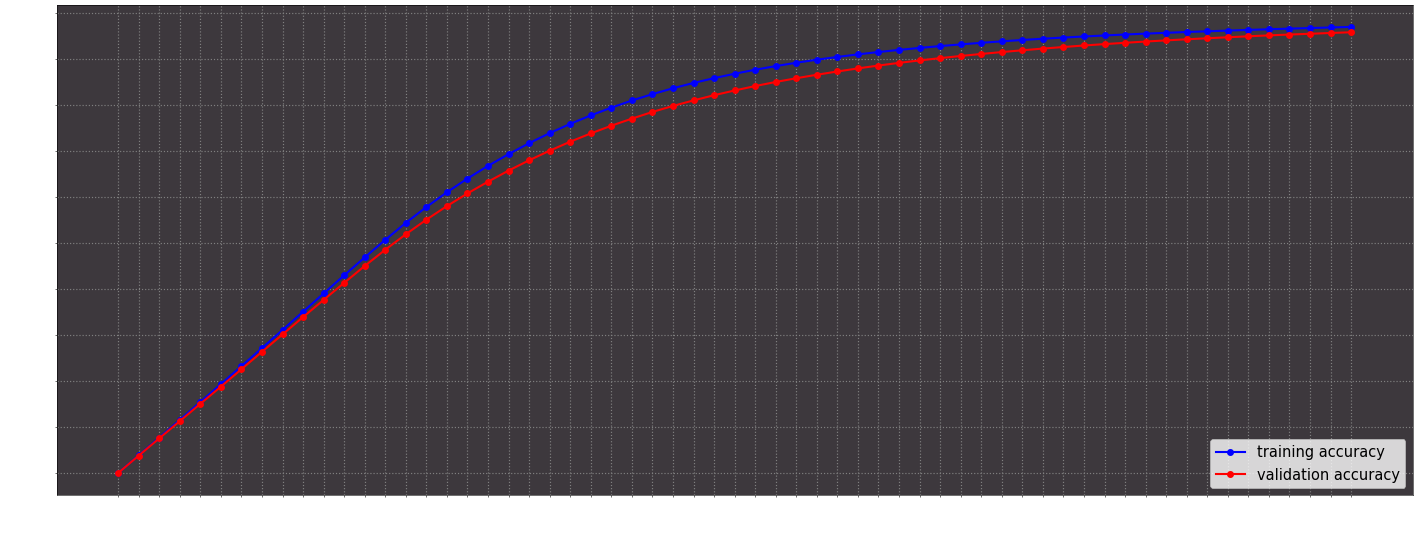

In [ ]:
#@title Code for making the graph
"""
checking effect of epsilon price on accuracy
"""

max_eps = 300

training_accs = []
testing_accs = []

for temp_epsilon in range(0, max_eps + 1, 5):
    training_accs.append(accuracy('train', temp_epsilon))
    testing_accs.append(accuracy('test', temp_epsilon))

width_in_inches = 35
height_in_inches = 13
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches),
    dpi=dots_per_inch)

plt.rcParams['axes.facecolor'] = '#3D383D'
plt.rcParams['legend.facecolor'] = 'white'

plt.plot(range(0, max_eps + 1, 5), training_accs, 'o-b', label='training accuracy', mew=4, linewidth=3)
plt.plot(range(0, max_eps + 1, 5), testing_accs, 'o-r', label='validation accuracy', mew=4, linewidth=3)

plt.legend(loc="lower right", fontsize=21)

plt.xlabel('Epsilon price in USD ($)', fontsize=30, color='white')
plt.ylabel('Accuracy (%)', fontsize=30, color='white')

plt.xticks(range(0, max_eps + 1, 5), fontsize=15, color='white')
plt.yticks(range(0, 101, 10), fontsize=18, color='white')

plt.grid(color='grey', linestyle=':', linewidth=1.7)

plt.show()
plt.close()

## Once the model is satisfiably good, it will be exported as a tf model to the drive to be uploaded to [mia](http://miamarketplace.com/).

In [ ]:
"""
saving the model and the files for uploading to mia
checking the tensorflow and python versions
"""

model.save('/content/drive/My Drive/MIA/', save_format='tf')

print(tf.__version__)
! python --version

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/MIA/assets
2.2.0
Python 3.6.9
